### Instalacja bibliotek

In [23]:
%pip install -r ../requirements.txt --quiet


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
from typing import Any, List

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import DataFrame

pd.set_option('display.max_columns', None)

### Wgranie danych treningowych

In [25]:
df = pd.read_csv('../data/sales_ads_train.csv')
df.head()

,ID,Cena,Waluta,Stan,Marka_pojazdu,Model_pojazdu,Wersja_pojazdu,Generacja_pojazdu,Rok_produkcji,Przebieg_km,Moc_KM,Pojemnosc_cm3,Rodzaj_paliwa,Emisja_CO2,Naped,Skrzynia_biegow,Typ_nadwozia,Liczba_drzwi,Kolor,Kraj_pochodzenia,Pierwszy_wlasciciel,Data_pierwszej_rejestracji,Data_publikacji_oferty,Lokalizacja_oferty,Wyposazenie
0,1,13900,PLN,Used,Renault,Grand Espace,Gr 2.0T 16V Expression,NaN,2005.0,213000.0,170.0,1998.0,Gasoline,232.0,Front wheels,Manual,minivan,5.0,blue,NaN,NaN,NaN,28/04/2021,"SŁONECZNA 1 - 99-300 Kutno, kutnowski, Łódzkie...","['ABS', 'Electric front windows', 'Drivers air..."
1,2,25900,PLN,Used,Renault,Megane,1.6 16V 110,III (2008-2016),2010.0,117089.0,110.0,1598.0,Gasoline,159.0,Front wheels,Manual,station_wagon,5.0,silver,NaN,NaN,16/06/2010,04/05/2021,"ul. Wiosenna 8 - 41-407 Imielin, Centrum (Polska)","['ABS', 'Electric front windows', 'Drivers air..."
2,3,35900,PLN,Used,Opel,Zafira,Tourer 1.6 CDTI ecoFLEX Start/Stop,C (2011-2019),2015.0,115600.0,136.0,1598.0,NaN,NaN,NaN,Manual,minivan,5.0,white,Denmark,NaN,NaN,03/05/2021,"Sianów, koszaliński, Zachodniopomorskie","['ABS', 'Electric front windows', 'Passengers ..."
3,4,5999,PLN,Used,Ford,Focus,1.6 TDCi FX Silver / Silver X,Mk2 (2004-2011),2007.0,218000.0,90.0,1560.0,Diesel,118.0,Front wheels,Manual,compact,5.0,blue,NaN,NaN,27/11/2007,02/05/2021,"Gdańsk, Pomorskie, Przymorze Wielkie","['ABS', 'Electric front windows', 'Drivers air..."
4,5,44800,PLN,Used,Toyota,Avensis,1.8,III (2009-),2013.0,NaN,NaN,1798.0,Gasoline,152.0,Front wheels,Manual,NaN,4.0,other,Poland,Yes,20/05/2013,02/05/2021,"Świdnik, świdnicki, Lubelskie","['ABS', 'Electric front windows', 'Drivers air..."


### Czyszczenie danych

**Czyszczenie danych**:<br>
*usuwamy rekordy z brakami w kluczowych cechach technicznych oraz kolumny, które są zbędne lub trudne do efektywnego wykorzystania.

In [26]:
def initial_cleaning(df: DataFrame) -> DataFrame:
    df = df.dropna(subset=['Waluta', 'Rok_produkcji'])
    df = df[~(df['Pojemnosc_cm3'].isnull() & df['Moc_KM'].isnull())]
    df = df.drop(columns=[
        'Pierwszy_wlasciciel', 
        'Data_publikacji_oferty',
        'Data_pierwszej_rejestracji', 
        'Emisja_CO2', 
        'Wersja_pojazdu', 
        'Generacja_pojazdu', 
        'ID',
        'Przebieg_km',
        'Lokalizacja_oferty',
        'Kolor',
        'Model_pojazdu',
        'Liczba_drzwi'
    ])

    return df

*konwertowanie EUR na PLN zgodnie z kursem z okresu zamieszczenia ogłoszeń

In [27]:
def convert_euro(df: DataFrame) -> DataFrame:
    conversion_rate = 4.5793
    mask = df['Waluta'] == 'EUR'
    df.loc[mask, 'Cena'] = df.loc[mask, 'Cena'] * conversion_rate

    return df.drop(columns=['Waluta'])

*kodowanie wybranych wartości z 'Liczba_drzwi' jako kategorie – tylko te z najwyższą korelacją z ceną; zmienna traktowana jako kategoryczna ze względu na różne kierunki zależności

In [28]:
def encode_liczba_drzwi(df: DataFrame) -> DataFrame:
    for num in range(2, 5):
        df[f'Liczba_drzwi_{num}'] = (df['Liczba_drzwi'] == num).astype(int)
    
    df = df.drop(columns=['Liczba_drzwi'])

    return df

*kodowanie wybranych krajów pochodzenia (Polska, Niemcy) – tylko te z istotną korelacją z ceną

In [29]:
def encode_kraj_pochodzenia(df: DataFrame) -> DataFrame:
    df['Kraj_pochodzenia_Polska'] = (df['Kraj_pochodzenia'] == 'Poland').astype(int)
    df['Kraj_pochodzenia_Niemcy'] = (df['Kraj_pochodzenia'] == 'Germany').astype(int)
    
    return df.drop(columns=['Kraj_pochodzenia'])

In [46]:
# df['Kolor_silver'] = (df['Kolor'] == 'silver').astype(int)

# df = df.drop(columns=['Kolor'])

*kodowanie wybranych elementów wyposażenia – tylko te o istotnej korelacji z ceną

In [30]:
import ast

def encode_equipment(df: DataFrame) -> DataFrame:

    def convert_to_list(e: Any) -> List[str]:
        try:
            return ast.literal_eval(e)
        except Exception:
            return []
    
    df['Wyposazenie'] = df['Wyposazenie'].apply(convert_to_list)
    
    equip_to_extract = ['CD', 'Rear view camera', 'LED lights', 'Daytime running lights', 'Rear parking sensors', 
                        'Heated rear seats', 'Leather upholstery', 'Heated front seats', 'Shift paddles', 
                        'Adjustable suspension', 'Electronically adjustable seats', 'Bluetooth', 'GPS navigation', 
                        'USB socket', 'Lane assistant', 'Blind spot sensor', 'Active cruise control', 'Start-Stop system', 
                        'Front parking sensors', 'Velor upholstery', 'Manual air conditioning', 'Parking assistant',
                       'Sunroof', 'Panoramic roof', 'Tinted windows', 'Speed limiter', 'Rain sensor', 'HUD(head-up display)',
                       'Four-zone air conditioning', ' Electrochromic rear view mirror', 'Electrochromic side mirrors', 
                        'Automatic air conditioning', 'Airbag protecting the knees']
    
    for e in equip_to_extract:
        df[f'has_{e}'] = df['Wyposazenie'].apply(lambda x: 1 if e in x else 0).astype(int)
    
    return df.drop(columns=['Wyposazenie'])

*kodowanie binarne kolumn dwuwartościowych z uzupełnieniem braków dominantą

In [31]:
def encode_binary(df: DataFrame, col: str)  -> DataFrame:
    mode = df[col].mode()[0]
    df[col] = df[col].fillna(mode)
    
    df[f'is_{mode}'] = (df[col] == mode).astype(int)

    return df.drop(columns=[col])

*uzupełnianie brakujących wartości w kolumnie 'Marka_pojazdu' na podstawie modelu – tylko jeśli dany model występuje jednoznacznie z jedną marką

In [32]:
def fill_brands(df: DataFrame) -> DataFrame:
    df_nonempty_model = df[df['Model_pojazdu'].notnull() & (df['Model_pojazdu'].str.strip() != "")]
    brand_counts = df_nonempty_model.groupby('Model_pojazdu')['Marka_pojazdu'].nunique()
    models_with_unique_brand = brand_counts[brand_counts == 1].index
    
    brand_mapping = df_nonempty_model[df_nonempty_model['Model_pojazdu'].isin(models_with_unique_brand)]\
        .groupby('Model_pojazdu')['Marka_pojazdu']\
        .agg(lambda x: x.dropna().unique()[0])
    
    mask_missing_brand = df['Marka_pojazdu'].isnull() & df['Model_pojazdu'].notnull()
    mask_missing_brand &= df['Model_pojazdu'].isin(brand_mapping.index)
    
    df.loc[mask_missing_brand, 'Marka_pojazdu'] = df.loc[mask_missing_brand, 'Model_pojazdu'].map(brand_mapping)

    return df

*uzupełnianie brakujących danych (np. typ nadwozia) na podstawie unikalnych kombinacji marka–model – tylko dla modeli przypisanych jednoznacznie do jednej marki

In [33]:
def fill_based_on_brands(df: DataFrame, cols: List[str]) -> None:
    df_nonnull = df.dropna(subset=['Marka_pojazdu', 'Model_pojazdu'])
    
    model_brand_counts = df_nonnull.groupby('Model_pojazdu')['Marka_pojazdu'].nunique()
    unique_models = model_brand_counts[model_brand_counts == 1].index
    
    for col in cols:
        mapping = (df_nonnull[df_nonnull['Model_pojazdu'].isin(unique_models)]
                   .dropna(subset=[col])
                   .groupby(['Marka_pojazdu', 'Model_pojazdu'])[col]
                   .agg(lambda x: x.value_counts().index[0]))

        mask = (df[col].isnull()) & \
            (df['Marka_pojazdu'].notnull()) & \
            (df['Model_pojazdu'].notnull()) & \
            (df['Model_pojazdu'].isin(unique_models))
        df.loc[mask, col] = df.loc[mask, ['Marka_pojazdu', 'Model_pojazdu']].apply(
            lambda row: mapping.get((row['Marka_pojazdu'], row['Model_pojazdu'])), axis=1)


*porządkowanie zmiennej kategorycznej: uzupełnienie braków, grupowanie rzadkich wartości, opcjonalne wyodrębnienie wybranych kategorii, kodowanie one-hot

In [34]:
def encode_categorical(df: DataFrame, col: str, group_val: str = '', threshold: int = 0, selected_vals: List[str] = None) -> None:
    mode = df[col].mode()[0]
    df.loc[:, col] = df[col].fillna(mode)

    if group_val:
        df.loc[:, col] = df[col].apply(lambda x: group_val if group_val in x else x)

    if selected_vals:
        df.loc[:, col] = df[col].apply(lambda x: x if x in selected_vals else 'other')

    if threshold:
        rare = df[col].value_counts()[df[col].value_counts() < threshold].index
        df.loc[:, col] = df[col].apply(lambda x: 'other' if x in rare or 'other' in x.lower() else x)

    print(df[col].value_counts())

    dummies = pd.get_dummies(df[col], prefix=col, drop_first=False)
    for c in dummies.columns:
        df.loc[:, c] = dummies[c]

    df.drop(columns=[col], inplace=True)

*usuwanie obserwacji z ceną powyżej zadanego percentyla – redukcja wpływu wartości odstających

In [35]:
def remove_outliers(df: DataFrame, percentile: float) -> DataFrame:
    threshold = df['Cena'].quantile(percentile)
    print(f'Wartość {percentile}. percentyla: {threshold}')
    
    return df[df['Cena'] <= threshold]

*imputacja braków w "Moc_KM" na podstawie "Pojemnosc_cm3" i na odwrót

In [36]:
from sklearn.linear_model import HuberRegressor

def fill_power_capacity(df: DataFrame) -> DataFrame:
    df_both = df.dropna(subset=['Pojemnosc_cm3', 'Moc_KM'])
    X_moc = df_both[['Pojemnosc_cm3']]
    y_moc = df_both['Moc_KM']
    
    huber_moc = HuberRegressor().fit(X_moc, y_moc)
    
    mask_moc = df['Moc_KM'].isnull() & df['Pojemnosc_cm3'].notnull()
    df.loc[mask_moc, 'Moc_KM'] = huber_moc.predict(df.loc[mask_moc, ['Pojemnosc_cm3']])
    
    df_both = df.dropna(subset=['Pojemnosc_cm3', 'Moc_KM'])
    X_poj = df_both[['Moc_KM']]
    y_poj = df_both['Pojemnosc_cm3']
    
    huber_poj = HuberRegressor().fit(X_poj, y_poj)
    
    mask_poj = df['Pojemnosc_cm3'].isnull() & df['Moc_KM'].notnull()
    df.loc[mask_poj, 'Pojemnosc_cm3'] = huber_poj.predict(df.loc[mask_poj, ['Moc_KM']])

    return df


In [37]:
def clean_data(df:DataFrame) -> DataFrame:
    df_with_brands = fill_brands(df)
    fill_based_on_brands(df_with_brands, ['Naped', 'Typ_nadwozia', 'Rodzaj_paliwa'])

    df_initially_cleaned = initial_cleaning(df_with_brands)
    df_with_pln = convert_euro(df_initially_cleaned)
    # df_with_drzwi_encoded = encode_liczba_drzwi(df_with_pln)
    df_with_kraj_encoded = encode_kraj_pochodzenia(df_with_pln)
    df_with_equipment_encoded = encode_equipment(df_with_kraj_encoded)
    df_with_stan_encoded = encode_binary(df_with_equipment_encoded, 'Stan')
    df_with_skrzynia_encoded = encode_binary(df_with_stan_encoded, 'Skrzynia_biegow')

    multicat_cols = [
        {'col': 'Marka_pojazdu', 'threshold': 5000, 'selected_vals': ['BMW', 'Opel', 'Mercedes-Benz', 'Renault', 'Citroen']},
        {'col': 'Typ_nadwozia', 'threshold': 5000, 'selected_vals': ['SUV', 'minivan', 'city-cars', 'compact']},
        {'col': 'Naped', 'group_val': '4x4'},
        {'col': 'Rodzaj_paliwa', 'threshold': 5000}
    ]
    
    for col_data in multicat_cols:
        encode_categorical(df_with_skrzynia_encoded, **col_data)
    
    df_cleaned = fill_power_capacity(df_with_skrzynia_encoded)
    return df_cleaned


In [38]:
df_cleaned = clean_data(df)
df_cut = remove_outliers(df_cleaned, 0.95)

Marka_pojazdu
other            93821
BMW              10409
Opel             10071
Mercedes-Benz     7467
Renault           6594
Name: count, dtype: int64
Typ_nadwozia
other      69055
SUV        25947
compact    19695
minivan    13665
Name: count, dtype: int64
Naped
Front wheels    93930
4x4             22123
Rear wheels     12309
Name: count, dtype: int64
Rodzaj_paliwa
Gasoline          61401
Diesel            56939
Gasoline + LPG     5460
other              4562
Name: count, dtype: int64
Wartość 0.95. percentyla: 200000.0


/tmp/ipykernel_68053/1340513405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut.drop(columns=['Model_pojazdu'], inplace=True)


In [39]:
df_cut.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121946 entries, 0 to 135396
Data columns (total 57 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Cena                                  121946 non-null  float64
 1   Rok_produkcji                         121946 non-null  float64
 2   Moc_KM                                121946 non-null  float64
 3   Pojemnosc_cm3                         121946 non-null  float64
 4   Kraj_pochodzenia_Polska               121946 non-null  int64  
 5   Kraj_pochodzenia_Niemcy               121946 non-null  int64  
 6   has_CD                                121946 non-null  int64  
 7   has_Rear view camera                  121946 non-null  int64  
 8   has_LED lights                        121946 non-null  int64  
 9   has_Daytime running lights            121946 non-null  int64  
 10  has_Rear parking sensors              121946 non-null  int64  
 11  has_H

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y = df_cut['Cena']
X = df_cut.drop(columns=['Cena'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# CV: MSE
cv_scores_mse = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Średnie MSE (CV) na danych treningowych:", -cv_scores_mse.mean())

# CV: MAE
cv_scores_mae = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Średnie MAE (CV) na danych treningowych:", -cv_scores_mae.mean())

y_val_pred = lr_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

print("MSE na zbiorze walidacyjnym:", mse_val)
print("MAE na zbiorze walidacyjnym:", mae_val)
print("R² na zbiorze walidacyjnym:", r2_val)

# df_test = pd.read_csv('../data/sales_ads_test.csv')
# test_predictions = lr_model.predict(df_test)
# pd.DataFrame({'Predicted_Cena': test_predictions}).to_csv('predicted_prices.csv', index=False)


Średnie MSE (CV) na danych treningowych: 462094411.10203904
Średnie MAE (CV) na danych treningowych: 14321.335330097005
MSE na zbiorze walidacyjnym: 446365997.9037977
MAE na zbiorze walidacyjnym: 14109.663485233574
R² na zbiorze walidacyjnym: 0.7565831062183531


In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Załóżmy, że df_cut zawiera oczyszczone dane, a 'Cena' jest zmienną docelową.
y = df_cut['Cena']  # używamy oryginalnej wartości
X = df_cut.drop(columns=['Cena'])

# Podział danych na zbiór treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Konwersja do float32
X_train = X_train.astype('float32')
X_val   = X_val.astype('float32')
y_train = y_train.astype('float32')
y_val   = y_val.astype('float32')

# Budowa modelu – prosty model sieci neuronowej
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1], )),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # brak aktywacji, bo zmienna docelowa jest ciągła
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

# Predykcje na zbiorze walidacyjnym (bez transformacji)
y_val_pred = model.predict(X_val).flatten()

# Obliczenie metryk na oryginalnej skali
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
mae_val = np.mean(np.abs(y_val - y_val_pred))

print(f"Validation MSE (zbior walidacyjny): {mse_val:.2f}")
print(f"Validation MAE (zbior walidacyjny): {mae_val:.2f}")
print(f"Validation R² (zbior walidacyjny): {r2_val:.4f}")


2025-03-25 20:12:33.809485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-25 20:12:33.810722: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
3049/3049 [==============================] - 5s 2ms/step - loss: 1684585984.0000 - mae: 31240.1582 - val_loss: 1121858176.0000 - val_mae: 25231.5254
Epoch 2/50
3049/3049 [==============================] - 4s 1ms/step - loss: 966593344.0000 - mae: 21817.5527 - val_loss: 877385472.0000 - val_mae: 20685.6484
Epoch 3/50
3049/3049 [==============================] - 4s 1ms/step - loss: 823343488.0000 - mae: 19419.1719 - val_loss: 775571072.0000 - val_mae: 19511.3047
Epoch 4/50
3049/3049 [==============================] - 4s 1ms/step - loss: 715441408.0000 - mae: 17821.6504 - val_loss: 651657152.0000 - val_mae: 16936.9629
Epoch 5/50
3049/3049 [==============================] - 4s 1ms/step - loss: 627257344.0000 - mae: 16623.4199 - val_loss: 579867584.0000 - val_mae: 15760.0889
Epoch 6/50
3049/3049 [==============================] - 4s 1ms/step - loss: 568274688.0000 - mae: 15915.8203 - val_loss: 537638976.0000 - val_mae: 15879.5771
Epoch 7/50
3049/3049 [============================

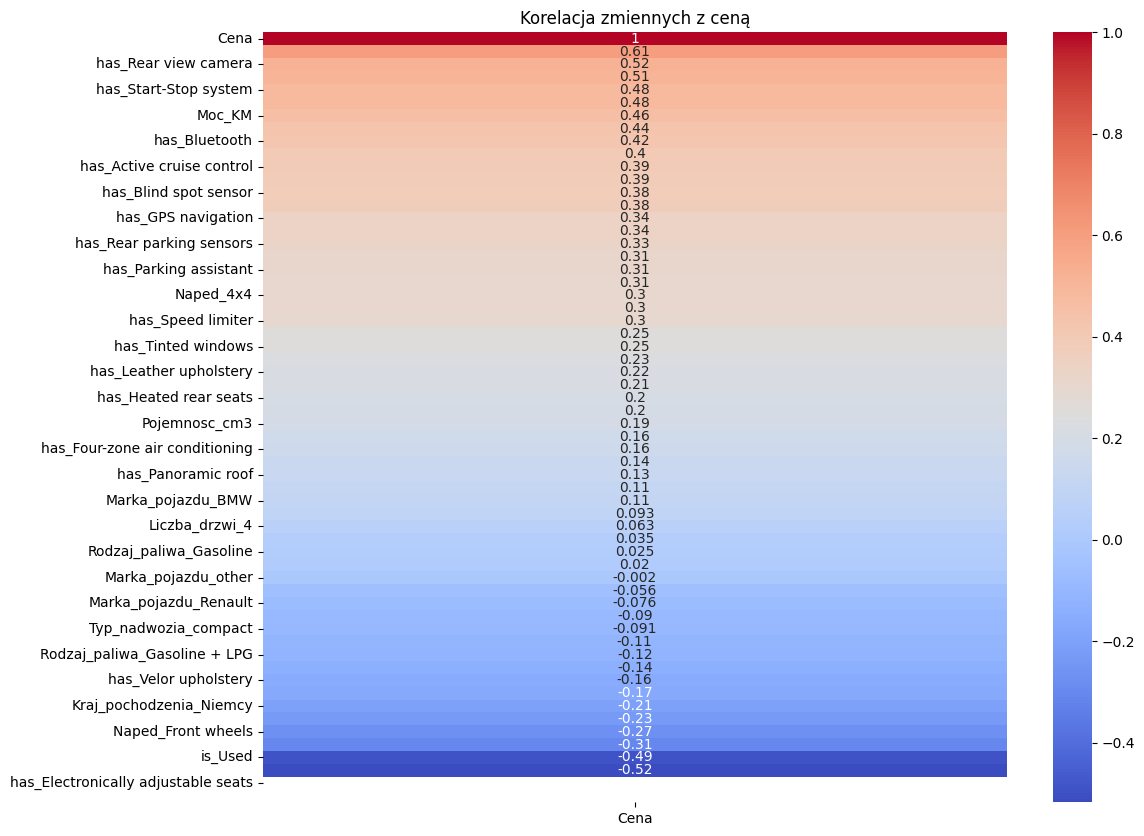

In [95]:
# Obliczenie korelacji dla zmiennych numerycznych
corr = df_cut.corr()

plt.figure(figsize=(12,10))
# Sortujemy zmienne względem korelacji z 'Cena'
corr_price = corr[['Cena']].sort_values(by='Cena', ascending=False)
sns.heatmap(corr_price, annot=True, cmap="coolwarm")
plt.title("Korelacja zmiennych z ceną")
plt.show()


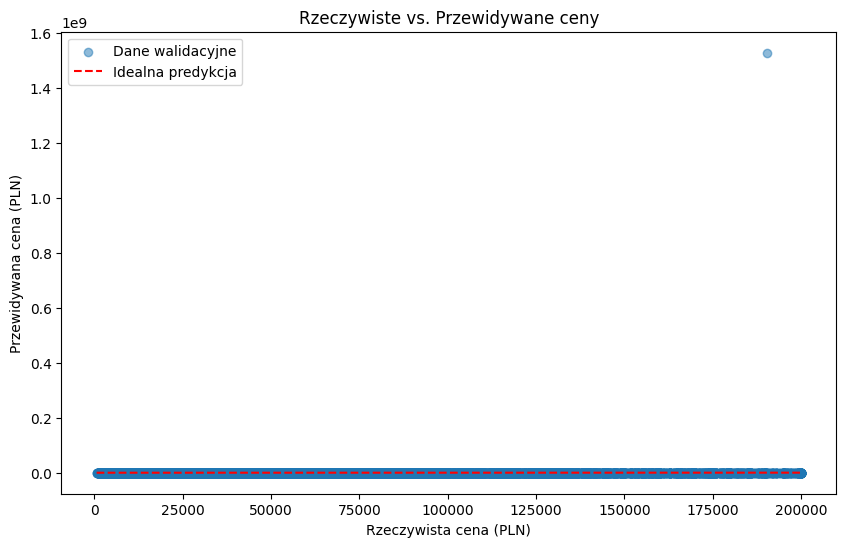

In [96]:
import matplotlib.pyplot as plt

# Zakładamy, że y_val_true i y_val_pred to jednowymiarowe tablice NumPy z rzeczywistymi i przewidywanymi cenami.
plt.figure(figsize=(10,6))
plt.scatter(y_val_true, y_val_pred, alpha=0.5, label="Dane walidacyjne")
# Rysujemy linię idealnych predykcji: y = x
plt.plot([y_val_true.min(), y_val_true.max()], [y_val_true.min(), y_val_true.max()], 'r--', label="Idealna predykcja")
plt.xlabel("Rzeczywista cena (PLN)")
plt.ylabel("Przewidywana cena (PLN)")
plt.title("Rzeczywiste vs. Przewidywane ceny")
plt.legend()
plt.show()


Feature importances:
Rok_produkcji: 0.5874
Moc_KM: 0.2171
is_Automatic: 0.0462
Pojemnosc_cm3: 0.0300
Naped_Front wheels: 0.0268
Kraj_pochodzenia_Polska: 0.0075
Rodzaj_paliwa_Gasoline: 0.0067
Typ_nadwozia_SUV: 0.0059
has_Front parking sensors: 0.0046
has_Shift paddles: 0.0028
has_CD: 0.0027
has_Leather upholstery: 0.0025
Liczba_drzwi_4: 0.0024
has_Rear view camera: 0.0024
Typ_nadwozia_station_wagon: 0.0023
has_Heated front seats: 0.0023
has_Parking assistant: 0.0022
has_LED lights: 0.0022
has_Lane assistant: 0.0021
has_Start-Stop system: 0.0021
has_Active cruise control: 0.0021
has_GPS navigation: 0.0021
Typ_nadwozia_other: 0.0021
has_Manual air conditioning: 0.0021
has_Velor upholstery: 0.0020
Typ_nadwozia_minivan: 0.0020
is_New: 0.0019
Rodzaj_paliwa_Diesel: 0.0019
has_USB socket: 0.0018
has_Daytime running lights: 0.0018
Typ_nadwozia_sedan: 0.0018
has_Blind spot sensor: 0.0017
has_Bluetooth: 0.0017
has_Adjustable suspension: 0.0017
Liczba_drzwi_2: 0.0016
Naped_4x4: 0.0016
has_Rear par

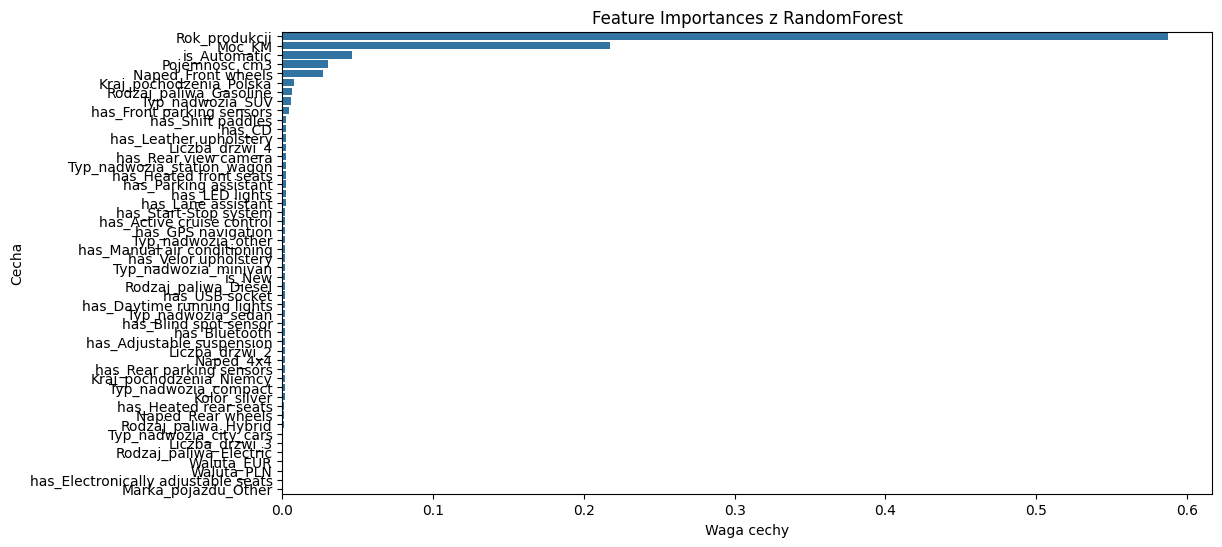

In [67]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

print("Feature importances:")
for f in range(len(features)):
    print(f"{features[indices[f]]}: {importances[indices[f]]:.4f}")

# Wizualizacja importancji
plt.figure(figsize=(12,6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Feature Importances z RandomForest")
plt.xlabel("Waga cechy")
plt.ylabel("Cecha")
plt.show()
